# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

In [2]:
import pytest
from ipytest import run_pytest, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 9881 / 11441 MB available
Created context handle <39306240>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks/cuda_cache


In [11]:
cuda_kernel = """
__global__ void matrixVectorKernel(double* c, double* A, double* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [12]:
def gpuMatrixVector(a, b):
    context.synchronize()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float64)
        b_g = GPUArray(b.shape, np.float64)
        c_g = GPUArray(a.shape[0], np.float64)
        context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set(a)
        context.synchronize()
        
    with Timer("b upload") as t:
        b_g.set(b)
        context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
        context.synchronize()

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float64)
    with Timer("Download") as t:
        c_g.get(c)
        context.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [13]:
nx = np.array([200, 400, 800, 1600, 3200, 6400, 8000, 10000])
ny = nx

print(nx, ny)

[  200   400   800  1600  3200  6400  8000 10000] [  200   400   800  1600  3200  6400  8000 10000]


In [14]:
times = np.empty_like(nx)
for i in range(len(nx)):
    print("Nx = " + str(nx[i]), flush=True)
    #Size of our test
    test_size = (nx[i], ny[i])

    #Create test input / output data
    with Timer("Create test data") as t:
        a = np.random.random(test_size).astype(np.float64)
        b = np.random.random((test_size[1], 1)).astype(np.float64)
    with Timer("Run whole function") as t:
        c = gpuMatrixVector(a, b)
    times[i] = t.msecs
    
print(nx*ny)
print(times)
    
    

"""fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()"""

Nx = 200


Create test data: 26.155949 ms
Data allocation: 0.541449 ms
A upload: 0.885248 ms
b upload: 0.368118 ms
Kernel execution: 0.438929 ms
Allocate c: 0.010014 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 0.414610 ms
Run whole function: 6.698847 ms


Nx = 400


Create test data: 4.423857 ms
Data allocation: 0.571966 ms
A upload: 0.626087 ms
b upload: 0.555992 ms
Kernel execution: 0.474453 ms
Allocate c: 0.013113 ms
Download: 0.455141 ms
Run whole function: 6.871939 ms


Nx = 800


Create test data: 16.211987 ms
Data allocation: 0.582457 ms
A upload: 0.907183 ms
b upload: 0.162363 ms
Kernel execution: 0.797510 ms
Allocate c: 0.010490 ms
Download: 0.414848 ms
Run whole function: 7.732630 ms


Nx = 1600


Create test data: 49.602270 ms
Data allocation: 0.710249 ms
A upload: 3.036737 ms
b upload: 0.114918 ms
Kernel execution: 1.367807 ms
Allocate c: 0.008583 ms
Download: 0.132799 ms
Run whole function: 12.615442 ms


Nx = 3200


Create test data: 205.117702 ms
Data allocation: 0.637770 ms
A upload: 11.430025 ms
b upload: 0.157595 ms
Kernel execution: 3.599882 ms
Allocate c: 0.009298 ms
Download: 0.247002 ms
Run whole function: 31.265259 ms


Nx = 6400


Create test data: 816.466093 ms
Data allocation: 1.041174 ms
A upload: 43.236017 ms
b upload: 0.398159 ms
Kernel execution: 13.270378 ms
Allocate c: 0.010014 ms
Download: 0.156879 ms
Run whole function: 105.490923 ms


Nx = 8000


Create test data: 1289.684296 ms
Data allocation: 1.953363 ms
A upload: 67.508459 ms
b upload: 0.237465 ms
Kernel execution: 20.682812 ms
Allocate c: 0.016928 ms
Download: 0.277758 ms
Run whole function: 156.710863 ms


Nx = 10000


Create test data: 2009.300232 ms
Data allocation: 1.632452 ms
A upload: 100.790024 ms
b upload: 0.322104 ms
Kernel execution: 29.491186 ms
Allocate c: 0.010967 ms
Download: 0.246763 ms
Run whole function: 221.282959 ms


[    40000    160000    640000   2560000  10240000  40960000  64000000
 100000000]
[  6   6   7  12  31 105 156 221]


'fig = plt.figure()\nplt.subplot(1,3,1)\nplt.imshow(a)\nplt.subplot(1,3,2)\nplt.imshow(b)\nplt.subplot(1,3,3)\nplt.imshow(c)\nfig.show()'

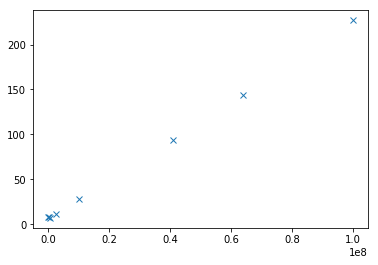

In [10]:
plt.figure()
plt.plot(nx*ny, times, 'x')

Sad = nan
Per element error: nan


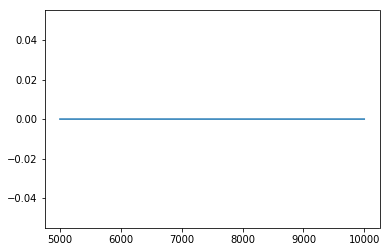

In [18]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
plt.plot(c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

In [ ]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1, 1), dtype=np.float32)
    b = 2*np.ones((1, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1, 2), dtype=np.float32)
    b = 2*np.ones((2, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(a.dot(b), rel=1e-3)
    
run_pytest(filename='MatrixVectorTesting.ipynb', pytest_options=['-vvv'])